In [1]:
SEED = 116

In [2]:
#autoload modules in notebook
%load_ext autoreload
%autoreload 2  

In [3]:
from itertools import combinations
import json
from sklearn.metrics import classification_report
from transformers import DistilBertTokenizer, TFDistilBertModel
import pandas as pd
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split
import tensorflow as tf
import cv2
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix, multilabel_confusion_matrix
import seaborn as sns
import os
from itertools import islice
from collections import defaultdict

import pickle 
import CLIP_model
import CLIP_data_load
import utils
import numpy as np
import train_utils

2023-09-04 22:34:25.259144: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-04 22:34:26.287781: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/ale/miniconda3/envs/tf2/lib/python3.11/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [4]:
from hyperparameters import *
bert_model_name = 'distilbert-base-uncased' #bert-base-multilingual-uncased

# Paths
all_images_path = 'dataset/resized_train/'
dataset_extract_location = 'dataset/'
project_location = '.'
all_captions_path = f'{project_location}/dataset/caption_prediction_train.csv'  
all_concept_ids_path = f'{project_location}/dataset/concept_detection_train.csv'
all_concepts_path = f'{project_location}/dataset/concepts.csv'

zip_dataset_location = f'{project_location}/dataset/resized_train.zip'

### Data load

In [5]:
#Merging all dataframes toghether into ID, caption, cuis, concepts
captionsDF = pd.read_csv(all_captions_path, sep='\t')
concept_id_df = pd.read_csv(all_concept_ids_path, sep='\t')
concept_df = pd.read_csv(all_concepts_path, sep=',')

captions_concepts_df = CLIP_data_load.preprocess_captions_concepts(captionsDF, concept_id_df, concept_df)

[nltk_data] Downloading package stopwords to /home/ale/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/ale/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [6]:
train_val, test = train_test_split(captions_concepts_df, test_size = test_percentage, shuffle = False, random_state = SEED)
train, val = train_test_split(train_val, test_size = validation_percentage, shuffle = False, random_state = SEED)

In [7]:
tokenizer = DistilBertTokenizer.from_pretrained(bert_model_name)

testList = CLIP_data_load.paths_captions_concepts_emb_list(
    test,
    all_images_path,
    tokenizer=tokenizer,
    max_len_captions=captions_input_shape[0],
    max_len_concepts=concepts_input_shape[0],
    remove_images_threshold=0,
)

100%|██████████| 16655/16655 [00:12<00:00, 1299.61it/s]


In [8]:
test_gen = CLIP_data_load.FusionGenerator(
    channels_first=False,
    preprocessing_function=None,
    data=testList,
    batch_size=batch_size,
    out_shape=img_shape[0:2],
    shuffle=False,
    model_version='base',
)

  0%|          | 0/130 [00:00<?, ?it/s]

2023-09-04 22:35:01.517204: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-09-04 22:35:01.703885: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-09-04 22:35:01.704065: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

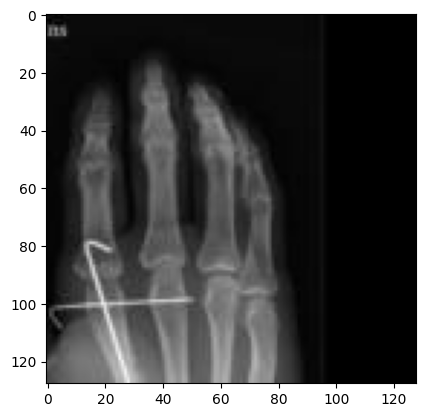

In [9]:
for i,(batch_image,batch_ids,batch_masks) in enumerate(tqdm(test_gen)):#8,64,64,3 and 8,512
#     img = cv2.imread(img_path)
#     img = cv2.resize(img, (img_size))
#     img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # convert BGR to RGB
    plt.imshow(batch_image[0,:,:])
    break

## Load model

In [10]:
import wandb
model_to_use = 'test_clip_base'

run = wandb.init(project="clip",name='inference_test')
artifact = run.use_artifact(f'calonca/clip/{model_to_use}:v0', type='model')
artifact_dir = artifact.download()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: alexlaconca (calonca). Use `wandb login --relogin` to force relogin


wandb: Downloading large artifact test_clip_base:v0, 337.71MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:0.9


In [11]:
bert_model = TFDistilBertModel.from_pretrained(bert_model_name)

model_loc = f"{artifact_dir}/{model_to_use}.h5"

loaded_model: CLIP_model.CLIP_base = tf.keras.models.load_model(
    model_loc,
    custom_objects={
        "TFDistilBertModel": bert_model,
        "CLIP_base": CLIP_model.CLIP_base,
        "ProjectorLayer": CLIP_model.ProjectorLayer,
        "clip_loss": CLIP_model.clip_loss,
    },
)  # type: ignore

2023-09-04 22:35:11.372917: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_transform.bias', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_layer_norm.bias']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the

In [12]:
def embed_img(batch_img):
  text_zeros = tf.zeros([batch_img.shape[0],*captions_input_shape])
  return embed(batch_img,text_zeros,text_zeros)[1]

def embed_txt(batch_ids,batch_att):
  image_zeros = tf.zeros([batch_ids.shape[0],*img_shape])
  return embed(image_zeros,batch_ids,batch_att)[0]

def embed(batch_img,batch_ids,batch_att):
    e_txt,e_img = loaded_model.predict_step((batch_img,batch_ids,batch_att))
    return e_txt.numpy(),e_img.numpy()

class PrecomputedEmbeddings:
    def __init__(self,emb_txt,emb_img,df):
        lenght = emb_txt.shape[0]
        self.ids = list(df['ID'])[:lenght]
        self.captions = list(df['caption'])[:lenght]
        self.concepts = list(df['concepts'])[:lenght]
        self.paths = [all_images_path+name for name in self.ids]
        self.text = emb_txt
        self.img = emb_img
        self.text_of = {id:text for id,text in zip(self.ids,self.text)}
        self.img_of = {id:img for id,img in zip(self.ids,self.img)}
        self.caption_of = {id:capt for id,capt in zip(self.ids,self.captions)}
    #len
    def __len__(self):
        return self.text.shape[0]
    
def get_precomputed_embeddings(save_path,data,force_recompute=False):
    if os.path.exists(save_path) and not force_recompute:
        with open(save_path, 'rb') as f:
            emb_data = pickle.load(f)
    else:
        e_txt, e_img = loaded_model.predict(data,workers=2)
        emb_data = PrecomputedEmbeddings(e_txt,e_img,test)
        with open(save_path, 'wb') as f:
            pickle.dump(emb_data, f)
    return emb_data

In [13]:
embed_test = get_precomputed_embeddings(f'{artifact_dir}/embed_test.pkl',test_gen,force_recompute=False)

In [14]:
# Print functions
def print_similar(id_simscore_tuples,embed_data,max_print_similar):

    similar = islice(reversed(id_simscore_tuples),0,max_print_similar)
    for i,(id,v) in enumerate(similar):
        print(f"{id} {v} {embed_data.caption_of[id]}")

def print_different(id_simscore_tuples,embed_data,max_print_different):

    reversed_vals = reversed(id_simscore_tuples[:max_print_different])
    for i,(id,v) in enumerate(reversed_vals):
        print(f"{id} {v} {embed_data.caption_of[id]}")

def show_top_n_images(id_simscore_tuples,embeds, max_print):
    similar = islice(reversed(id_simscore_tuples),0,max_print)
    for i,(id,v) in enumerate(similar):
        print(f"{id} {v} {embeds.caption_of[id]}")
        img_path = f'{all_images_path}{id}'
        #read color image
        img = cv2.imread(img_path)
        plt.imshow(img)
        plt.show()

# Get functions

def get_similar_text(text,ids,embed_texts):  
  
    tokenized_word = CLIP_data_load.construct_encoding(text,tokenizer,captions_input_shape[0], return_tensors="tf")
    e_txt = embed_txt(tokenized_word['input_ids'],tokenized_word['attention_mask'])
    
    distances_vals = np.dot(embed_texts,e_txt.T) #Cosine similarity. The vectors are already normalized
    distances = dict(zip(ids,distances_vals))

    id_simscore_tuples = sorted(distances.items(), key=lambda item: item[1])

    return id_simscore_tuples

def get_similar_images_from_text(text,ids,embed_imgs):  
  
  tokenized_word = CLIP_data_load.construct_encoding(text,tokenizer,captions_input_shape[0], return_tensors="tf")
  e_txt = embed_txt(tokenized_word['input_ids'],tokenized_word['attention_mask'])

  distances_vals = np.dot(embed_imgs,e_txt.T) #Cosine similarity. The vectors are already normalized
  distances = dict(zip(ids,distances_vals))

  id_simscore_tuples = sorted(distances.items(), key=lambda item: item[1])

  return id_simscore_tuples

def get_similar_images(image_name, ids, embed_imgs):
    image_path = f'{all_images_path}{image_name}.jpg'
    image = cv2.imread(image_path, cv2.IMREAD_COLOR)
    e_img = embed_img(image[None,:])

    distances_vals = np.dot(embed_imgs, e_img.T)  # Cosine similarity. The vectors are already normalized
    distances = dict(zip(ids, distances_vals))

    id_simscore_tuples = sorted(distances.items(), key=lambda item: item[1])

    return id_simscore_tuples

# Functions to call

def print_similar_text(query,embed_data,max_print_similar = 10,max_print_different = 10):

    id_simscore_tuples = get_similar_text(query,embed_data.ids,embed_data.text)

    print_similar(id_simscore_tuples,embed_data,max_print_similar)

    print('...')

    print_different(id_simscore_tuples,embed_data,max_print_different)

def show_similar_images_from_path(image_name, embed_data, max_print_similar=10, max_print_different=10):
    id_simscore_tuples = get_similar_images(image_name, embed_data.ids, embed_data.img)

    show_top_n_images(id_simscore_tuples, embed_data, max_print_similar)

    print_different(id_simscore_tuples,embed_data,max_print_different)


def show_similar_images_from_text(query,embeds,max_print_similar = 10,max_print_different = 10):
    id_simscore_tuples = get_similar_images_from_text(query,embeds.ids,embeds.img)
    show_top_n_images(id_simscore_tuples,embeds, max_print_similar)

# Metrics

def new_rr(distances_vals,target_image_path, paths, n):
    
    full_dist = [paths[i] for i in np.argsort(distances_vals)[::-1]]

    distances =  full_dist[0:n]

    # Get rank based on the distance between the most similar image (in position 0 of the array) and the target image
    if target_image_path in distances:
        return 1/(distances.index(target_image_path) + 1)
    else:
        return 0

def compute_mrr(embed_data, n):
    collect_rr = []
    sim_matrix = np.dot(embed_data.text,embed_data.img.T) #Cosine similarity. Image to caption.

    pbar = tqdm(range(len(embed_data.paths)))
    for i in pbar:#8,64,64,3 and 8,512
        path = embed_data.paths[i]
        newrr = new_rr(sim_matrix[i,:],path,embed_data.paths,n)
        # print(newrr)
        collect_rr.append(newrr)
        if i % 1000 == 0:
            pbar.set_description(f"Average score = {np.average(collect_rr)}")

    return np.average(collect_rr)

def new_recall_at_k(distances_vals,target_image_id, ids, k):
    
    full_dist = [ids[i] for i in np.argsort(distances_vals)[::-1]]

    act_set = set([target_image_id])
    pred_set = set(full_dist[0:k])
    result = len(act_set & pred_set) / float(len(act_set)) # The & operator is used for the set intersection
    # Get rank based on the distance between the most similar image (in position 0 of the array) and the target image
    return result

def compute_recall_at_k(embed_data, k):
    sim_matrix = np.dot(embed_data.text,embed_data.img.T) #Cosine similarity. Image to caption.
    collect_rr = []
    pbar = tqdm(range(len(embed_data.paths)))
    for i in pbar:#8,64,64,3 and 8,512
        id = embed_data.ids[i]
        newrr = new_recall_at_k(sim_matrix[i,:].T,id,embed_data.ids,k)
        collect_rr.append(newrr)
        if i % 1000 == 0:
            pbar.set_description(f"Average score = {np.average(collect_rr)}")

    return np.average(collect_rr)



# Inference

In [15]:
print_similar_text("an image of an mri",embed_test,max_print_similar = 10,max_print_different = 10)

2023-09-04 22:35:19.865037: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600


ImageCLEFmedCaption_2022_train_077106.jpg [0.95992666] chest computed tomography mass measure cardiomegaly size upper mediastinum
ImageCLEFmedCaption_2022_train_077091.jpg [0.9587633] retroperitoneal hematoma coronal computed tomography abdomen aneurysm left low quadrant narrow associate large left low quadrant hematoma bold
ImageCLEFmedCaption_2022_train_076886.jpg [0.95710385] orbital tomography solid tumor protrude choroid
ImageCLEFmedCaption_2022_train_078937.jpg [0.95342183] sagittal computed tomography reconstruction pseudokidney longitudinal appearance contain intussusceptum segment bowel white mesenteric fat vessel orange intraluminar lipomatous lesion red asterisk
ImageCLEFmedCaption_2022_train_073979.jpg [0.9533686] magnetic resonance magnetic resonance imaging contrast cervical spine sagittal view awholespine magnetic resonance imaging time contrast clearly increase contrast enhancement around spinous process suggestive possible softtissue inflammatory process anabscess form

In [16]:
# print('Image -> Caption MRR@100 :', compute_mrr(embed_test, 100))
k = 100
# print(f'Image -> Caption   R@{k}:', compute_recall_at_k(embed_test, k))

ImageCLEFmedCaption_2022_train_079562.jpg 0.9999994039535522 diffusely enlarge numerous hypodense lesion lobe suggestive metastasis


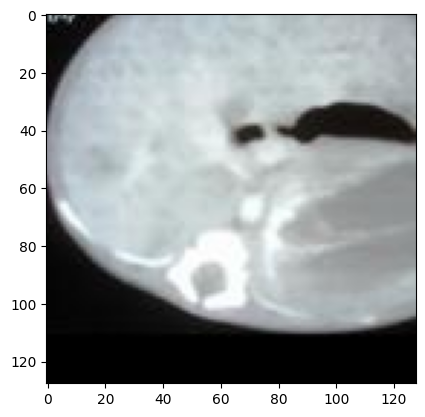

ImageCLEFmedCaption_2022_train_081607.jpg 0.658344030380249 neck tilt non-tender define angle vertical line draw tip sternum line connect center upper endplate tip sternum slope angle upper end plate horizontal line thoracic inlet angle transient ischemic attack define angle form perpendicular line upper endplate line connect center upper endplate sternum tip cervical angle measure angle horizontal line low endplate horizontal line low endplate


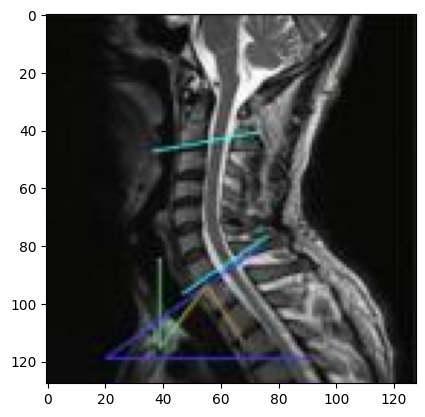

ImageCLEFmedCaption_2022_train_078090.jpg -0.4657553434371948 coronary view abdominal tomography ovoid fatty mass hyperattenuate ring central high attenuate line inflamed epiploic appendix thbe lesion believe due thrombosbe vessel
ImageCLEFmedCaption_2022_train_069097.jpg -0.4974965453147888 lateral radiography cervical spine anterior osteophyte


In [17]:
show_similar_images_from_path('ImageCLEFmedCaption_2022_train_079572',embed_test,max_print_similar = 2,max_print_different=2)

ImageCLEFmedCaption_2022_train_067752.jpg [0.24800792] chest radiograph enlargment cardiac shadow cardiothoracic ratio


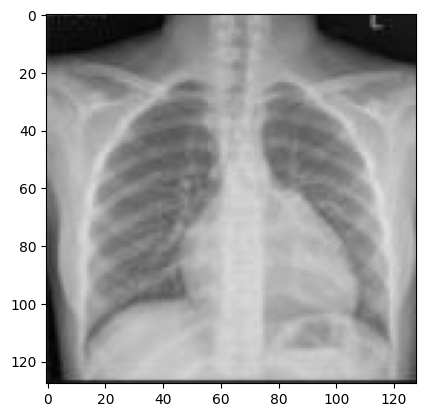

ImageCLEFmedCaption_2022_train_067429.jpg [0.2461262] preoperative scapular view radiograph right scapula


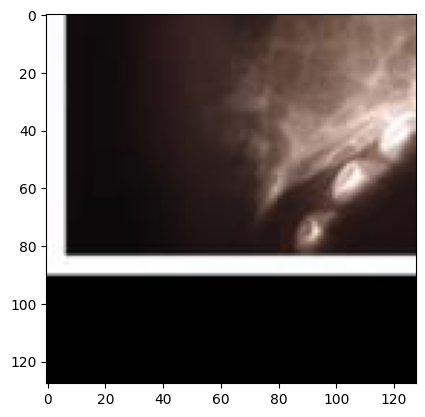

In [18]:
show_similar_images_from_text('chest',embed_test,max_print_similar=2)

### Multi class classification accuracy 

In [67]:
tk_labels, _ , one_hot_labels,  = train_utils.build_zero_shot_metric(
    test,
    tokenizer,
    concepts_input_shape[0],
    captions_input_shape[0],
    preceding_caption="An image of ",
    num_classes=zs_num_classes,
)
# embed_test.concepts = list(df["concepts"])[: embed_test.text.shape[0]]
# lbt = np.argmax(embed_test.concepts, axis=1)
# print test['labels']

# print(Counter(lbt))
# print(embed_test.concepts)

In [20]:
utils.print_metric(test,zs_num_classes)

(78017,) ['Plain x-ray' 'Fracture of metacarpal bone' 'Reduced' ...
 'Decreased translucency' 'Homogeneity' 'Chest']
total test samples: 16655
total concepts with duplicates: 78017
unique concepts: 6478
max concepts per sample: 111
min concepts per sample: 2
avg concepts per sample: 16.14803183921453

concepts of sample 0: {'Plain x-ray', 'Fracture of metacarpal bone', 'Reduced'}
concepts of sample 1: {'Structure of head of humerus', 'Deliveries by destructive operation', 'Malignant - descriptor', 'Structure of left shoulder region', 'disrupted', 'Plain x-ray', 'Cortex of bone'}
concepts of sample 2: {'Trochlear nerve structure', 'Plain x-ray'}
concepts of sample 3: {'Plain x-ray', 'Computed Tomography Scanning Systems', 'Measurement'}
concepts of sample 4: {'Pathological fracture', 'Measures', 'Maximal (qualifier value)', 'Left humerus', 'Dimensions', 'Proximal', 'Neck', 'Plain x-ray'}

most common concepts: 
[('X-Ray Computed Tomography', 6025), ('Plain x-ray', 4435), ('Magnetic Reso

In [66]:
class LocalLogger():
    def __init__(self):
        self.allvalues = defaultdict(list)

    def log(self,name_value_dict={}):
        for k,v in name_value_dict.items():
            self.allvalues[k].append(v)

local_logger = LocalLogger()

emb_fun = lambda : embed_txt(tk_labels['input_ids'], tk_labels['attention_mask'])

zero_shot_callback = train_utils.ZeroShotSingleLabelCallBack(
    model=loaded_model,
    gen=test_gen,
    zs_labels=one_hot_labels,
    logger=local_logger,
    emb_fun=emb_fun,
    precomputed_e_img=embed_test.img,
)   

In [65]:
zero_shot_callback.on_epoch_end(-1)

zero_shot_accuracy:  0.03608596588459881


### functions from older zero shot setup

In [ ]:
# sample_labes has shape (num_samples,num_classes)
def add_other_class(samples_labels):
    # if a sample has only zeros concatenate a 1 at the end of the array
    # otherwise concatenate a 0
    other_class = np.array([1 if np.sum(sample) == 0 else 0 for sample in samples_labels])
    return np.concatenate((samples_labels,other_class[:,None]),axis=1)

In [ ]:
similarity_treshold = 0.01 # Hyperparameter. Image that have similarity higher then the treshold will belong to the class

print(e_labels.shape)
#compute similarity between each image and label
similarities = np.dot( embed_test.img,e_labels.T)
one_hot_labels = np.array(embed_test.concepts)
#remove fourth class

sim_old = similarities.copy()
labels_old = one_hot_labels.copy()

similarities[similarities < similarity_treshold] = 0
similarities[similarities >= similarity_treshold] = 1

# print number of ones in each row of similarities
print(np.sum(similarities))
print(np.sum(one_hot_labels))


similarities = add_other_class(similarities)
one_hot_labels = add_other_class(one_hot_labels)

print(f'ground truth: {one_hot_labels}')
print(f'predictions: {similarities}')
# print(add_other_class(similarities))
# compute multi class metrics
print('Multi class accuracy:', accuracy_score(one_hot_labels, similarities))
# single class accuracy
one_hot_max_labels = one_hot_labels.argmax(axis=1)
max_one_hot_similarities = similarities.argmax(axis=1)


print('Single class accuracy:', accuracy_score(one_hot_max_labels, max_one_hot_similarities))

matrix = confusion_matrix(one_hot_max_labels, sim_old.argmax(axis=1),normalize='true')
print('Single class confusion matrix:')
#plot matrix
plt.figure(figsize=(8,8))
lb = concepts# + ['other']
sns.heatmap(matrix, annot=True, fmt='.2f', cmap='Blues', xticklabels=lb, yticklabels=lb)
# add x and y labels
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# multi label confusion matrix
matrix = multilabel_confusion_matrix(one_hot_labels, similarities)
print(matrix[0])
print(matrix[1])
print(matrix[2])
# plot confusion matrix for each class
for i in range(num_classes):
    #plot matrix
    plt.figure(figsize=(2,2))
    #set title to class name
    plt.title(lb[i])
    xlb = ['pred F','pred T']
    ylb = ['F','T']
    mat = matrix[i]/np.linalg.norm(matrix[i])
    # cut numbers with more than 2 decimals
    sns.heatmap(mat, annot=True, fmt='.2f', cmap='Blues', xticklabels=xlb, yticklabels=ylb)
    print()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np


def find_best_treshold(similarities, one_hot_labels):
    best_treshold = 0
    best_acc = 0
    sim_copy = similarities.copy()
    progress = tqdm(np.arange(0, 1, 0.01))
    acc_values = []  # list to store accuracy values for each threshold
    for treshold in progress:
        similarities = sim_copy.copy()
        similarities[similarities < treshold] = 0
        similarities[similarities >= treshold] = 1
        acc = accuracy_score(one_hot_labels, similarities)
        acc_values.append(acc)  # add accuracy value to list
        if acc > best_acc:
            best_acc = acc
            best_treshold = treshold
            progress.set_description(f"Best treshold: {best_treshold}, Best acc: {best_acc}")
    # plot accuracy values
    plt.plot(np.linspace(0, 1, num=len(acc_values)), acc_values)
    plt.xlabel('Threshold')
    plt.ylabel('Accuracy')
    plt.title('Accuracy vs. Threshold')
    plt.show()
    plt.close()
    return best_treshold, best_acc

similarities = np.dot(embed_test.img, e_labels.T)
one_hot_labels = np.array(embed_test.concepts)
best_treshold, best_acc = find_best_treshold(similarities, one_hot_labels)

In [ ]:
#print predicted classes abor the treshold for each sample
tc = test.copy().reset_index(drop=True)
for i, (id,caption,cuis,concepts) in tc.iterrows():
    if i >= len(embed_test):
        break
    # get image embedding
    img = embed_test.img_of[id]
    # compute similarity between image and labels
    similarities = np.dot( img,e_labels.T)
    # get predicted labels
    predicted_labels = [concepts[i] for i in np.where(similarities > best_treshold)[0]]
    concept_with_labels_removed = [concept for concept in concepts if concept in concepts]
    print(f'predicted labels: {predicted_labels}')
    print(f'ground truth    : {concept_with_labels_removed}')
    print()
    print(i)

